In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import sequence
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
BASE_PATH = "/content/drive/My Drive/Colab Notebooks"
EPOCHS = 20
BATCH_SIZE = 4

In [ ]:
def get_vocab(fname):

    with open(fname, 'r') as the_file:
        data = sorted(the_file.read().split('\n'))
        data = {k: v for v, k in enumerate(data)}
        the_file.close()
    return data

In [ ]:
def generate_model(user_vocab_size, obj_vocab_size, out_dim=16, lstm_units=16, nop=8):

    # user encoder LSTM
    inpu = Input(shape=(None, ))
    outu = Embedding(user_vocab_size, out_dim)(inpu)
    _, _, cu = LSTM(lstm_units, return_state=True)(outu)
    # object encoder LSTM
    inpo = Input(shape=(None, ))
    outo = Embedding(obj_vocab_size, out_dim)(inpo)
    _, _, co = LSTM(lstm_units, return_state=True)(outo)
    # club cu and co as a weighted average and use it for further classification
    # Set variables as trainable so that they can be backpropgated and learnt
    Wu = tf.Variable(GlorotUniform()(shape=(cu.shape[1], nop)), trainable=True)
    Wo = tf.Variable(GlorotUniform()(shape=(co.shape[1], nop)), trainable=True)
    W = tf.Variable(GlorotUniform()(shape=(nop, )), trainable=True)
    # using the complete essence of all the attributes (of both user and object)
    # predict the permission level
    out = tf.nn.softmax(W + tf.matmul(cu, Wu) + tf.matmul(co, Wo)) 
    model = Model(inputs=[inpu, inpo], outputs=out)
    return model

In [ ]:
uad = get_vocab("{}/user_attr.txt".format(BASE_PATH))
oad = get_vocab("{}/obj_attr.txt".format(BASE_PATH))
nua = len(uad) + 1
noa = len(oad) + 1
with open(BASE_PATH + "/rules.txt") as the_file:
    rules = the_file.read().split('\n')
    the_file.close()

In [ ]:
Xu, Xo, Y = [], [], []
# Permissions are of the RSC (read-set-correct)
# R, S and C take binary values (0 or 1)
# Hence, in decimal, permissions lie between 0-7
for rule in rules:
    (UA, OA, p) = rule.split(';')
    Y.append(int(p))
    Xu.append([uad[x]+1 for x in UA.split(' ')])
    Xo.append([oad[x]+1 for x in OA.split(' ')])
Xu = sequence.pad_sequences(Xu)
Xo = sequence.pad_sequences(Xo)

In [ ]:
# create a train-test split on the data
Xu_train, Xu_test, Xo_train, Xo_test, Y_train, Y_test = train_test_split(Xu, Xo, Y, test_size=0.1)
# if required, create a validation split here
X_train = [tf.convert_to_tensor(Xu_train), tf.convert_to_tensor(Xo_train)]
X_test = [tf.convert_to_tensor(Xu_test), tf.convert_to_tensor(Xo_test)]
Y_train = tf.convert_to_tensor(Y_train)
Y_test = tf.convert_to_tensor(Y_test)

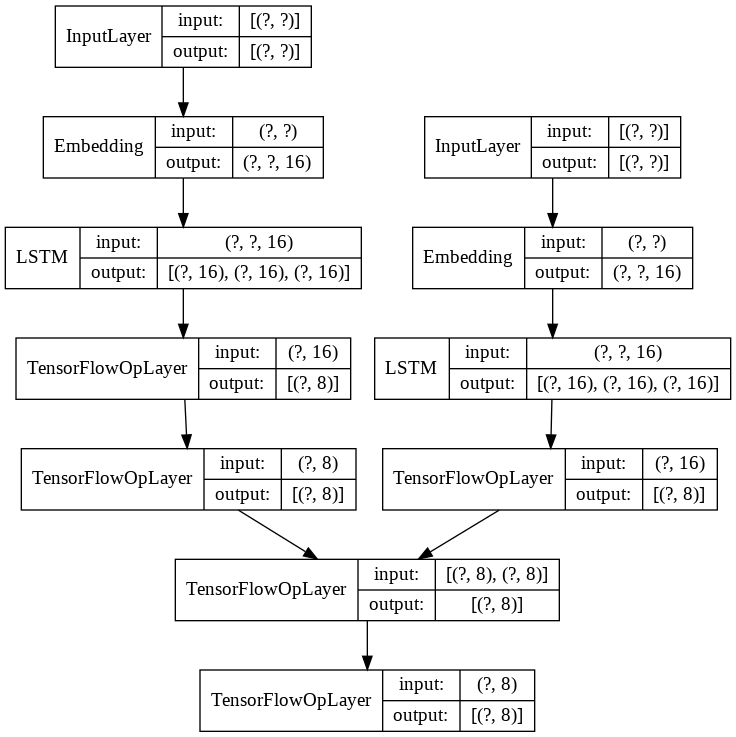

In [ ]:
# generate the model and compile it
model = generate_model(nua, noa)
model.compile(optimizer=Adam(learning_rate=0.01),
              loss="sparse_categorical_crossentropy",
              metrics=["sparse_categorical_accuracy"])
# train the model (pass train data)
# works better and faster with GPU
# replace X and Y with train split
model.fit(X_train, 
          Y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE,
          verbose=0)

In [ ]:
# test the model (pass test data)
# works better and faster with GPU
# replace X and Y with test split
model.evaluate(X_test, Y_test)
preds = model.predict(X_test)
print(tf.argmax(preds, axis=-1))

1/1 [==============================] - 0s 2ms/step - loss: 2.4984 - sparse_categorical_accuracy: 0.0000e+00
tf.Tensor([1 0], shape=(2,), dtype=int64)
